In [1]:
import requests
from bs4 import BeautifulSoup,SoupStrainer
import pandas as pd
from IPython.display import Markdown, display,HTML,Image
from selenium import webdriver
import time
from pandas.plotting import table 
import matplotlib.pyplot as plt
from html2image import Html2Image
hti = Html2Image(browser='edge')

In [2]:
# get the solution links
pages = ['https://www.janestreet.com/puzzles/archive/index.html',
         'https://www.janestreet.com/puzzles/archive/page2/index.html',
         'https://www.janestreet.com/puzzles/archive/page3/index.html',
         'https://www.janestreet.com/puzzles/archive/page4/index.html',
         'https://www.janestreet.com/puzzles/archive/page5/index.html',
         'https://www.janestreet.com/puzzles/archive/page6/index.html',
         'https://www.janestreet.com/puzzles/archive/page7/index.html',
         'https://www.janestreet.com/puzzles/archive/page8/index.html',
         'https://www.janestreet.com/puzzles/archive/page9/index.html',
         'https://www.janestreet.com/puzzles/archive/page10/index.html',
         'https://www.janestreet.com/puzzles/archive/page11/index.html',
         'https://www.janestreet.com/puzzles/archive/page12/index.html']  
links = ['https://www.janestreet.com/puzzles/current-puzzle/']
for url in pages:
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    links += ['https://www.janestreet.com/'+i['href'] for i in soup.find_all('a', {'class' :'solution-link'})]   

In [3]:
# scrape the names of solvers
participants = []
order = 1
driver = webdriver.Firefox()
for url in links:
    driver.get(url)
    time.sleep(5)
    htmlSource = driver.page_source
    soup = BeautifulSoup(htmlSource, 'html.parser')
    participants += [[str(url).split("/")[-1],i.split(" (")[0],order] for i in soup.find_all('p', {'class' :'correct-submissions'})[0].stripped_strings]
    order +=1

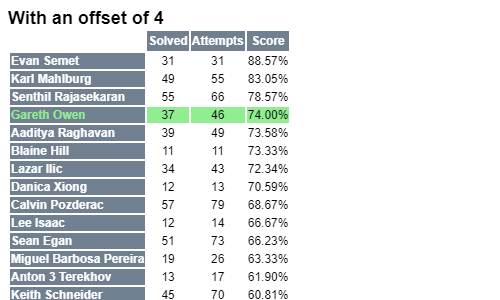

In [8]:
# Work out the scores with an offset. Count as attempted all those since the name appeared on a leaderboard.
# No adjustments for similar names etc
# Borrowed the offset idea from this (much more professionally done) tableau league table 
# https://public.tableau.com/app/profile/heidi.stockton/viz/PuzzlesofJaneStreet/JaneStreet

def df_format(styler,caption=""):
    font_to_use = 'arial'
    styler.format({'Score':'{:.2%}','Solved':'{:.0f}','Attempted':'{:.0f}'})
    styler.set_table_attributes("style='display:inline'")
    styler.hide(axis=0,names=True)
    styler.set_caption(caption)
    styler.set_table_styles([{'selector': 'td', 'props': [('text-align', 'center'),
                                                          ('font-size', '12px') ,
                                                          ('font-family',font_to_use )]},
                             {'selector': '.col_heading', 'props': [('text-align', 'center'),
                                                                    ('width', '30px'),
                                                                    ('background-color', 'slategrey'),
                                                                    ('color', 'white'),
                                                                   ('font-size', '12px'),
                                                                    ('font-family',font_to_use )]},
                             {'selector': '.row_heading', 'props': [('text-align', 'left'),
                                                                    ('background-color', 'slategrey'),
                                                                    ('color', 'white'),
                                                                    ('font-size', '12px'),
                                                                    ('font-family',font_to_use )]},
                             {'selector': 'caption', 'props': [ ('font-size', '18px'),
                                                               ('font-weight','bold'),
                                                               ('text-align', 'left'),
                                                               ('font-family',font_to_use )]},
                            ])
    styler.apply(lambda x: ['background: lightgreen'if x.name == 'Gareth Owen'  else '' for i in x], axis=1)
    my_name =[{'selector': '.row_heading', 'props': 'color : lightgreen'}]
    styler.set_table_styles({'Gareth Owen': my_name},axis=1,overwrite=False)
                                                      
    return styler

outputs = []

for newcomer_offset in [4]:
    df = pd.DataFrame(participants,columns = ['puzzle','Name','Order'])
    df['Name']=df['Name'].str.lstrip("1234567890. ")
    df2 = df[['Name','Order']].groupby('Name').agg({'Name':['count'],'Order': ['max']})
    df2.columns = [' '.join(col).strip() for col in df2.columns.values]
    df2.columns = ['Solved','Attempts']
    df2['Score']=df2['Solved']/(df2['Attempts']+ newcomer_offset)
    outputs += [df2.sort_values(['Score','Solved'],ascending=False)[:15].style.pipe(df_format,caption="With an offset of "+str(newcomer_offset))._repr_html_()]

hti.screenshot(html_str="".join(outputs), save_as='first.png',size=(500,300))
display(Image('first.png'))

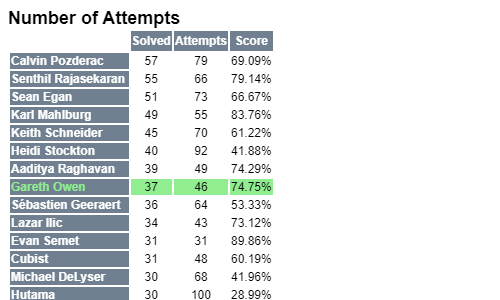

In [5]:
outputs = df2.sort_values('Solved',ascending=False)[:15].style.pipe(df_format,caption="Number of Attempts")._repr_html_()
hti.screenshot(html_str="".join(outputs), save_as='second.png',size=(500,300))
display(Image('second.png'))

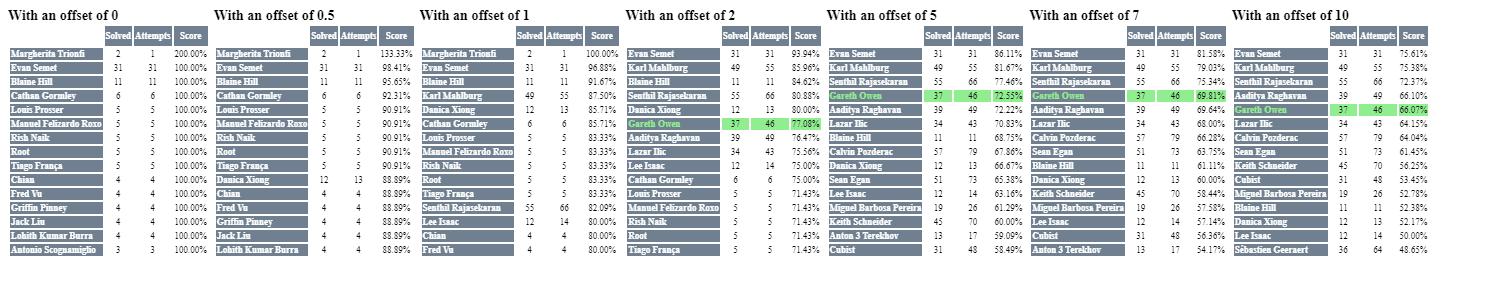

In [6]:
def df_format(styler,caption=""):
    styler.format({'Score':'{:.2%}','Solved':'{:.0f}','Attempted':'{:.0f}'})
    styler.set_table_attributes("style='display:inline'")
    styler.hide(axis=0,names=True)
    styler.set_caption(caption)
    styler.set_table_styles([{'selector': 'td', 'props': [('text-align', 'center'),
                                                          ('font-size', '9px')]},
                             {'selector': '.col_heading', 'props': [('text-align', 'center'),
                                                                    ('width', '20px'),
                                                                    ('background-color', 'slategrey'),
                                                                    ('color', 'white'),
                                                                   ('font-size', '9px')]},
                             {'selector': '.row_heading', 'props': [('text-align', 'left'),
                                                                    ('background-color', 'slategrey'),
                                                                    ('color', 'white'),
                                                                    ('font-size', '9px')]},
                             {'selector': 'caption', 'props': [ ('font-size', '14px'),('font-weight','bold'),('text-align', 'left')]},
                            ])
    styler.apply(lambda x: ['background: lightgreen'if x.name == 'Gareth Owen'  else '' for i in x], axis=1)
    my_name =[{'selector': '.row_heading', 'props': 'color : lightgreen'}]
    styler.set_table_styles({'Gareth Owen': my_name},axis=1,overwrite=False)
                                                      
    return styler

outputs = []

for newcomer_offset in [0,0.5,1,2,5,7,10]:
    df = pd.DataFrame(participants,columns = ['puzzle','Name','Order'])
    df['Name']=df['Name'].str.lstrip("1234567890. ")
    df2 = df[['Name','Order']].groupby('Name').agg({'Name':['count'],'Order': ['max']})
    df2.columns = [' '.join(col).strip() for col in df2.columns.values]
    df2.columns = ['Solved','Attempts']
    df2['Score']=df2['Solved']/(df2['Attempts']+ newcomer_offset)
    outputs += [df2.sort_values(['Score','Solved'],ascending=False)[:15].style.pipe(df_format,caption="With an offset of "+str(newcomer_offset))._repr_html_()]

hti.screenshot(html_str="".join(outputs), save_as='third.png',size=(1500,300))
display(Image('third.png'))

In [7]:
import xlwings as xw

sht = xw.Book().sheets[0]
sht.range('a1').options(index=False).value =  df